In [1]:
# Import required dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import sys

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Import custom modules
import simulator

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 8)))

# constants
FIGURE_SAVE_LOCATION = "../data/figures/04design/"
FIGURE_PREFILE = "simulator_"

In [2]:
tp = 2
dp = 8 
bs = 16
device_num = 320

sequence_length = 4383
decode_length = 1210

args = simulator.ModelArgs()
gpu_list = simulator.get_gpu_info('../device/gpu_info.csv', decoding_mode=False)

gemm_group_per_device = math.ceil(args.n_routed_experts / device_num)

In [3]:
time_ms = simulator.prefill_time(
    args,
    gpu_list['H800'],
    sequence_length,
    kv_cache_rate=0.563,
    tp_num=tp,
    dp_num=dp,
)

print(f"Prefill time: {time_ms} ms")

Prefill time: 302.0553242764904 ms


In [4]:
time_ms, throughput = simulator.decode_time(
    args,
    gpu_list['H800'],
    tp_num=4,
    bs_num=64,
    seq_len=sequence_length,
    decode_len=decode_length,
    gemm_group_per_device=gemm_group_per_device,
    device_num=device_num,
    print_flag=False,
)

print(f"Decode time: {time_ms} ms")
print(f"Throughput: {throughput} tokens/s")

Decode time: 17.85995941107182 ms
Throughput: 3583.4347955082617 tokens/s


In [5]:
total_time_ms = 0
for current_decode_length in range(decode_length):
    time_ms, _ = simulator.decode_time(
        args,
        gpu_list['H800'],
        tp_num=tp,
        bs_num=bs,
        seq_len=sequence_length + current_decode_length,
        decode_len=decode_length - current_decode_length,
        gemm_group_per_device=gemm_group_per_device,
        device_num=device_num,
        print_flag=False,
    )
    total_time_ms += time_ms

print(f"Decode time: {total_time_ms} ms")

Decode time: 15405.610756165308 ms


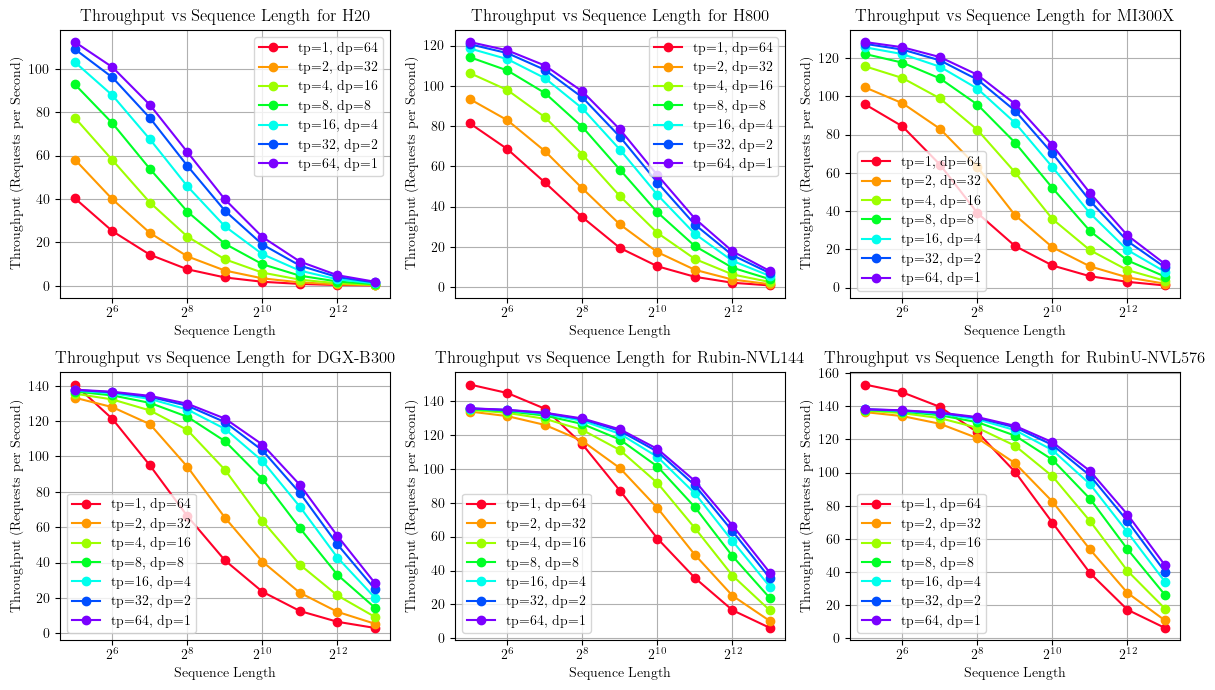

In [6]:
# for a given number of GPUs, we need to find the best tp/dp config
test_gpus = ['H20', 'H800', 'MI300X', 'DGX-B300', 'Rubin-NVL144', 'RubinU-NVL576']

num_gpus = 64
configs = []
for tp in range(1, num_gpus + 1):
    if num_gpus % tp == 0:
        dp = num_gpus // tp
        configs.append((tp, dp))

sequence_lengths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

# Iterate over each GPU type and plot
for i, gpu_type in enumerate(test_gpus):
    results = []
    for seq_len in sequence_lengths:
        for tp, dp in configs:
            time_ms = simulator.prefill_time(
                args,
                gpu_list[gpu_type],
                seq_len,
                kv_cache_rate=0.563,
                tp_num=tp,
                dp_num=dp,
            )

            time_s = time_ms / 1000
            request_per_second = 1 / time_s

            results.append({
                'tp': tp,
                'dp': dp,
                'sequence_length': seq_len,
                'request_per_second': request_per_second,
            })

    # Build DataFrame
    df = pd.DataFrame(results)

    # Plot request_per_second vs sequence length for the current GPU type
    ax = axes[i]
    for tp, dp in configs:
        series = (
            df[(df.tp == tp) & (df.dp == dp)]
            .set_index('sequence_length')['request_per_second']
        )
        ax.plot(
            series.index, series.values,
            marker='o',
            label=f"tp={tp}, dp={dp}"
        )
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Throughput (Requests per Second)')
    ax.set_title(f'Throughput vs Sequence Length for {gpu_type}')
    ax.legend()
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}prefill_throughput_vs_seq_len.pdf", bbox_inches='tight', format="pdf")

Average Deltas:
tp=1, dp=64, delta=-32.58%
tp=2, dp=32, delta=-30.09%
tp=4, dp=16, delta=-21.11%
tp=8, dp=8, delta=-13.61%
tp=16, dp=4, delta=-8.02%
tp=32, dp=2, delta=-4.34%
tp=64, dp=1, delta=-2.17%


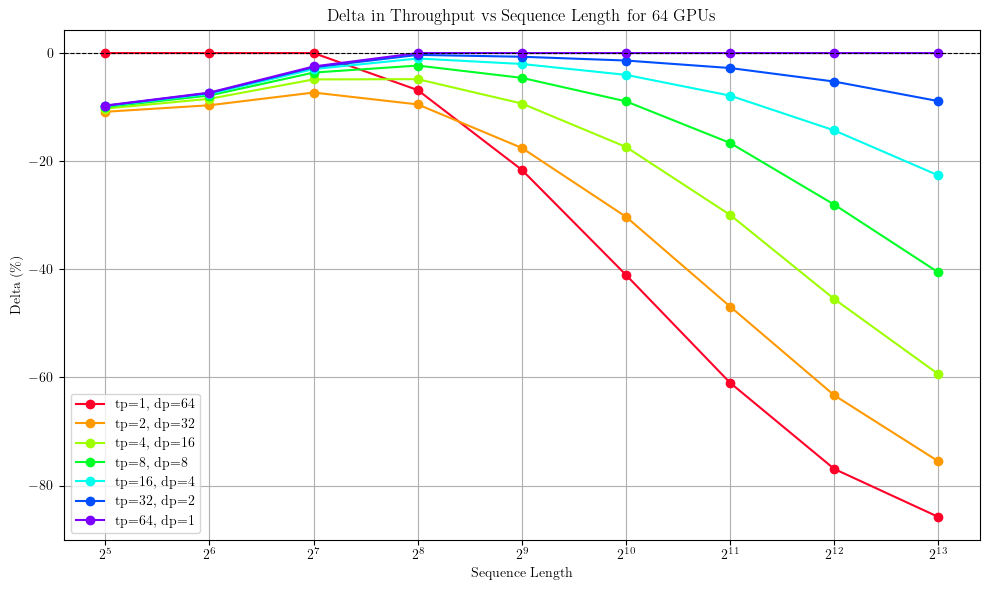

In [7]:
# take the df and find the best tp/dp config for each sequence length
best_configs = df.loc[df.groupby('sequence_length')['request_per_second'].idxmax()]

# calculate delta (percentage difference) between the best config and the others
def calculate_delta(row, best_row):
    if best_row['request_per_second'] == 0:
        return 0
    return (row['request_per_second'] - best_row['request_per_second']) / best_row['request_per_second'] * 100

# Add delta column to the DataFrame
df['delta'] = df.apply(
    lambda row: calculate_delta(row, best_configs[best_configs['sequence_length'] == row['sequence_length']].iloc[0]),
    axis=1
)

# calculate the average delta for each tp/dp config
avg_deltas = df.groupby(['tp', 'dp'])['delta'].mean().reset_index()
configs = avg_deltas[['tp', 'dp']].values.tolist()
avg_deltas['delta'] = avg_deltas['delta'].apply(lambda x: f"{x:.2f}%")
print("Average Deltas:")
for tp, dp, delta in avg_deltas.values:
    print(f"tp={tp}, dp={dp}, delta={delta}")

# plot the difference in throughput
plt.figure(figsize=(10, 6))
for tp, dp in configs:
    series = (
        df[(df.tp == tp) & (df.dp == dp)]
        .set_index('sequence_length')['delta']
    )
    plt.plot(
        series.index, series.values,
        marker='o',
        label=f"tp={tp}, dp={dp}"
    )
plt.xscale('log', base=2)
plt.xlabel('Sequence Length')
plt.ylabel('Delta (\\%)')
plt.title(f'Delta in Throughput vs Sequence Length for {num_gpus} GPUs')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Infinite time for tp=1, dp=8, seq_len=32, decode_len=1000
Infinite time for tp=2, dp=8, seq_len=32, decode_len=1000
Infinite time for tp=4, dp=8, seq_len=32, decode_len=1000
Infinite time for tp=8, dp=8, seq_len=32, decode_len=1000
Infinite time for tp=1, dp=8, seq_len=64, decode_len=1000
Infinite time for tp=2, dp=8, seq_len=64, decode_len=1000
Infinite time for tp=4, dp=8, seq_len=64, decode_len=1000
Infinite time for tp=8, dp=8, seq_len=64, decode_len=1000
Infinite time for tp=1, dp=8, seq_len=128, decode_len=1000
Infinite time for tp=2, dp=8, seq_len=128, decode_len=1000
Infinite time for tp=4, dp=8, seq_len=128, decode_len=1000
Infinite time for tp=8, dp=8, seq_len=128, decode_len=1000
Infinite time for tp=1, dp=8, seq_len=256, decode_len=1000
Infinite time for tp=2, dp=8, seq_len=256, decode_len=1000
Infinite time for tp=4, dp=8, seq_len=256, decode_len=1000
Infinite time for tp=8, dp=8, seq_len=256, decode_len=1000
Infinite time for tp=1, dp=8, seq_len=512, decode_len=1000
Infin

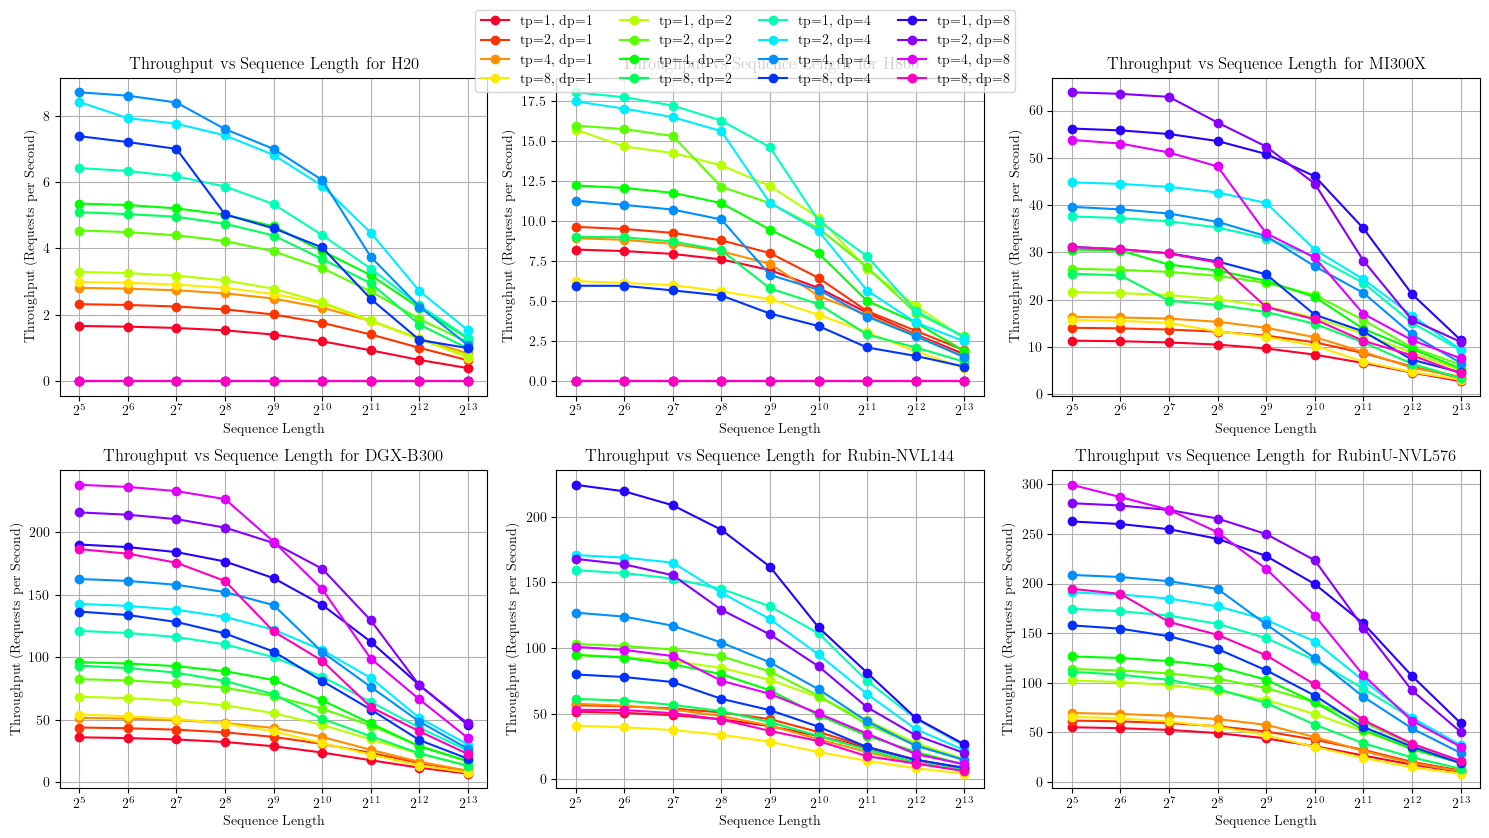

In [8]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 16)))

num_gpus = 64
tp_list = []
dp_list = []
for tp in range(1, 8 + 1):
    if num_gpus % tp == 0:
        tp_list.append(tp)
for dp in range(1, 8 + 1):
    if num_gpus % dp == 0:
        dp_list.append(dp)

decode_len_avg = 1000
sequence_lengths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Iterate over each GPU type and plot
for i, gpu_type in enumerate(test_gpus):
    results = []
    for seq_len in sequence_lengths:
        for tp in tp_list:
            for dp in dp_list:
                loop_num_gpus = num_gpus / dp

                # find max bs for this tp/dp
                max_bs = simulator.check_max_bs(
                    args,
                    gpu_list[gpu_type],
                    tp_num=tp,
                    seq_len=seq_len + current_decode_length,
                    decode_len=decode_len_avg - current_decode_length,
                    gemm_group_per_device=math.ceil(args.n_routed_experts / loop_num_gpus),
                    device_num=loop_num_gpus,
                )

                # round max bs to the nearest multiple of 8, maximum 1024, minimum 8
                max_bs = min(max_bs, 1024)
                batch_size = max_bs - (max_bs % 8)
                batch_size = max(batch_size, 8)
                
                total_time_ms = 0
                for current_decode_length in __builtins__.range(1, decode_len_avg, 1):
                    time_ms, _ = simulator.decode_time(
                        args,
                        gpu_list[gpu_type],
                        tp_num=tp,
                        bs_num=batch_size,
                        seq_len=seq_len + current_decode_length,
                        decode_len=decode_len_avg - current_decode_length,
                        gemm_group_per_device=math.ceil(args.n_routed_experts / loop_num_gpus),
                        device_num=loop_num_gpus,
                    )

                    # don't continue if the time is infinite
                    if time_ms == np.inf:
                        total_time_ms = np.inf
                        print(f"Infinite time for tp={tp}, dp={dp}, seq_len={seq_len}, decode_len={decode_len_avg}")
                        break
                    else:
                        total_time_ms += time_ms

                time_s = total_time_ms / 1000
                request_per_second = (1 / time_s * batch_size ) * dp if total_time_ms != np.inf else 0

                results.append({
                    'tp': tp,
                    'dp': dp,
                    'bs': batch_size,
                    'sequence_length': seq_len,
                    'request_per_second': request_per_second,
                })

    # Build DataFrame
    df = pd.DataFrame(results)

    # Plot request_per_second vs sequence length for the current GPU type
    ax = axes[i]
    for dp in dp_list:
        for tp in tp_list:
            series = (
                df[(df.tp == tp) & (df.dp == dp)]
                .set_index('sequence_length')['request_per_second']
            )
            ax.plot(
                series.index, series.values,
                marker='o',
                label=f"tp={tp}, dp={dp}"
            )
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Throughput (Requests per Second)')
    ax.set_title(f'Throughput vs Sequence Length for {gpu_type}')
    ax.grid(True)

# Add a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}decode_throughput_vs_seq_len.pdf", bbox_inches='tight', format="pdf")


Average Deltas:
tp=1, dp=1, delta=-82.44%
tp=1, dp=2, delta=-66.75%
tp=1, dp=4, delta=-40.92%
tp=1, dp=8, delta=-6.25%
tp=2, dp=1, delta=-79.79%
tp=2, dp=2, delta=-62.43%
tp=2, dp=4, delta=-35.63%
tp=2, dp=8, delta=-4.51%
tp=4, dp=1, delta=-78.53%
tp=4, dp=2, delta=-61.49%
tp=4, dp=4, delta=-37.65%
tp=4, dp=8, delta=-17.72%
tp=8, dp=1, delta=-81.76%
tp=8, dp=2, delta=-69.49%
tp=8, dp=4, delta=-56.24%
tp=8, dp=8, delta=-49.88%


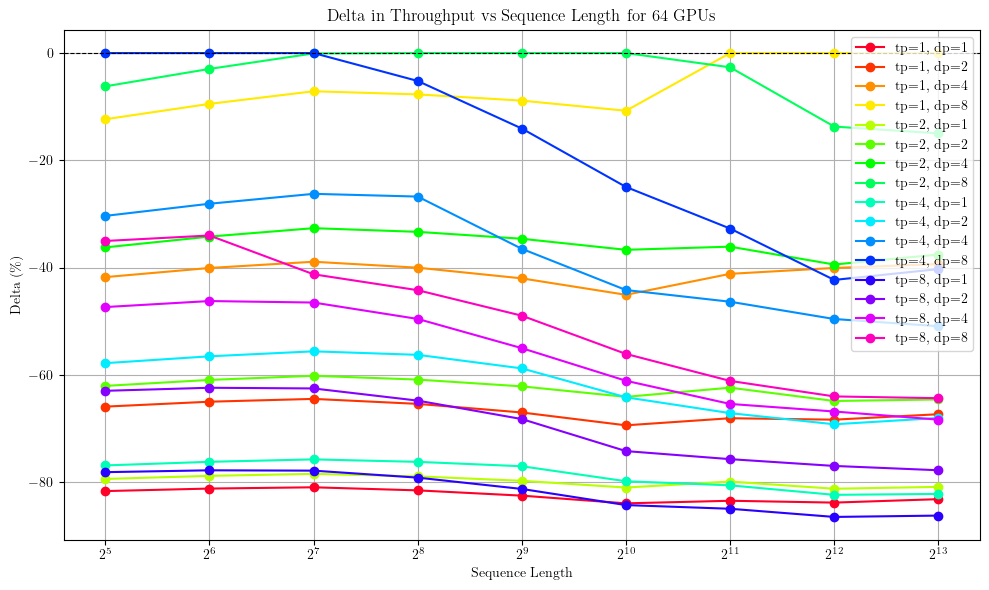

In [9]:
# take the df and find the best tp/dp config for each sequence length
best_configs = df.loc[df.groupby('sequence_length')['request_per_second'].idxmax()]

# calculate delta (percentage difference) between the best config and the others
def calculate_delta(row, best_row):
    if best_row['request_per_second'] == 0:
        return 0
    return (row['request_per_second'] - best_row['request_per_second']) / best_row['request_per_second'] * 100

# Add delta column to the DataFrame
df['delta'] = df.apply(
    lambda row: calculate_delta(row, best_configs[best_configs['sequence_length'] == row['sequence_length']].iloc[0]),
    axis=1
)

# calculate the average delta for each tp/dp config
avg_deltas = df.groupby(['tp', 'dp'])['delta'].mean().reset_index()
configs = avg_deltas[['tp', 'dp']].values.tolist()
avg_deltas['delta'] = avg_deltas['delta'].apply(lambda x: f"{x:.2f}%")
print("Average Deltas:")
for tp, dp, delta in avg_deltas.values:
    print(f"tp={tp}, dp={dp}, delta={delta}")

# plot the difference in throughput
plt.figure(figsize=(10, 6))
for tp, dp in configs:
    series = (
        df[(df.tp == tp) & (df.dp == dp)]
        .set_index('sequence_length')['delta']
    )
    plt.plot(
        series.index, series.values,
        marker='o',
        label=f"tp={tp}, dp={dp}"
    )
plt.xscale('log', base=2)
plt.xlabel('Sequence Length')
plt.ylabel('Delta (\\%)')
plt.title(f'Delta in Throughput vs Sequence Length for {num_gpus} GPUs')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()